 <h1>  <center> Markowitz Portfolio Theory  </center </h1> 

![title](http://blog.fidaonline.com/wp-content/uploads/2017/07/MARKOWITZ-IN-PILLOLE.jpg)



Markowitz's Portfolio theory has been published in the early '50s but it still one of the most valid intuitions in the portfolio optimization research.

Markowitz's theory is based on two fundamentals hypothesis: 

* The investors are risk-averse.

* The investors want to maximize their returns.

\
Given these constraints, every security can be mapped in a two-dimensional space.

The first dimension is Expected Return, the second one is Volatility.

The Expected Return is the  average of the returns and Volatility can be defined as the deviation from this Expected Return.

In a more statistical perspective Volatility is the Standard Deviation of the returns based on historical values.

\
To better understand Markowitz's work i want to refresh the  following concepts:

* Risk :
It is a measure of uncertainty and is defined as an adverse outcome.
The risk is composed of two subtypes of risks.

Systematic and Market risk.

Systematic risk is the inevitable risk, the non-diversifiable risk present in every investment.

The Market risk instead can be reduced because it is the result of the relationship between the securities in terms of returns and variability.  

\
A quick example:

If the market of cars falls, a diversified portfolio composed of different sectors stocks ,won't suffer as a single sector one.
In the well-diversified portfolio not all the stocks are connected, so the loss will be reduced. 

In the most common optimization, the time frame analysis is yearly based.


In the following Notebook i will demonstrate Markowitz's theory step by step .

I'll be using  Python to perform calculations and Quandl for data acquisition.


Quanld : https://www.quandl.com/


# Import Libraries



In [1]:
import matplotlib.gridspec as gridspec
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas_datareader as dr 
import requests
import quandl

import random 
quandl.ApiConfig.api_key = 'qt-YYRXCjaqaQsF4denS'# " write your password here "


#from jupyterthemes import jtplot
#jtplot.style()

# Data Ingestion

In [2]:
#Create a webscraping object and store the wiki link
wikitable = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',header=0)[0]
# Query the InformationTechnology sector.
#NOTE: Take securities that belongs to the same sector is not a smart choice !!.
my_wiki_df = wikitable[
                       (wikitable['GICS Sector']=='Information Technology') |
                       (wikitable['GICS Sector']=='Health Care')  ]


# Select tickers in the IT_wiki_df Symbols
tickers = [ ticker for ticker in set(my_wiki_df.Symbol)]
# Fetch data from Quandl add .9 after the "/" to get  close price only.
df = quandl.get(["WIKI/{}".format(ticker) for ticker in tickers],start_date = '2015-01-01')

# Select just the Adj.Close of each stock 
dfc = df[[ column for column in df.columns if '- Adj. Close' in column]]
# Rename columns , we want no spaces or - in the names
dfc.columns = [column[5:9].strip().replace('-','').strip() for column in dfc.columns]
# Preview

In [3]:
# Store tickers  by sector in two list.
Health_Care_companies      = my_wiki_df[my_wiki_df['GICS Sector'] == 'Health Care']['Symbol'].values.tolist() 
Information_Tech_companies = my_wiki_df[my_wiki_df['GICS Sector'] == 'Information Technology']['Symbol'].values.tolist()


#quandl gave me issues  with these tickers so i will drop them :
for i in ['CDW', 'ANET', 'NLOK', 'KEYS']:
    Information_Tech_companies.remove(i)

I used Python to web scrape Wikipedia table and get the tickers for Information Technology and Health Care sector.

\
Then i used Quandl API to get daily data and save all into a pandas data frame.

\
I just need close price, so i'v filtered the close price and stored all data into a new data frame called dfc.

All the tickers filtered by sector are stored in two different lists.
They will be usefull later.

In [4]:
# Preview
dfc.head()

,WU,LH,AMGN,HPQ,TMO,MXIM,XRAY,INCY,CDNS,AGN,...,ADP,ABC,LDOS,ALXN,HPE,AAPL,FLT,BAX,APH,DXC
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,16.363626,111.42,149.545908,16.767144,126.672931,28.943875,51.173581,73.76,18.83,256.710453,...,78.100827,86.383854,29.173296,186.60,NaN,103.863957,150.26,38.047462,52.270400,NaN
2015-01-05,16.208478,112.39,147.768828,16.487969,124.932810,28.500203,50.818825,74.22,18.40,254.293236,...,78.044566,85.648550,28.713448,182.17,NaN,100.937944,143.78,37.102893,51.315422,NaN
2015-01-06,16.181098,110.60,143.008126,16.362965,123.766137,28.376707,50.188147,71.49,17.91,252.787428,...,77.392866,86.116471,28.659348,177.95,NaN,100.947444,142.25,36.905675,50.662530,NaN
2015-01-07,16.025950,112.54,148.002655,16.554638,127.473782,29.035354,51.488920,74.45,18.42,262.753496,...,78.072696,87.835362,29.125959,187.93,NaN,102.362951,143.21,37.082133,51.529805,NaN
2015-01-08,16.345373,115.57,147.469531,16.950482,128.798648,29.712297,52.760129,73.21,18.61,266.448669,...,79.863699,88.035900,29.207108,183.80,NaN,106.295968,146.12,38.042272,52.533506,NaN


# Mapping Securities in the Expected Return and Volatility Space

Like I've said earlier Markowitz mapped the securities based on Returns and Volatility.

We just have daily price . To get returns we have to use logarithm returns. 

Why log ? 

To evaluate correctly a compounded return we can use log returns since it is a good approximation of the real compounded return.
The simple percentage change is not always correct when there are great returns or falls.



Here's a well-made explanation.
link: https://www.youtube.com/watch?v=0aQbadbhpgQ
 
It's not a big deal use log instead of the simple percentage change,so even if it sounds complicated at first is just a way to ensure the correct result.

In [5]:
# Create the log return , i use iloc because some companies has nans values
dfln = dfc.pct_change().apply(lambda x: np.log(1+x))

Given that we have a daily based data we compute mean and multiply it for 250, the std number of trading days to get annual expected returns.

\
For Volatility, we do the same thing except that we add a square root at the end.

Let's map in the space all the securities.

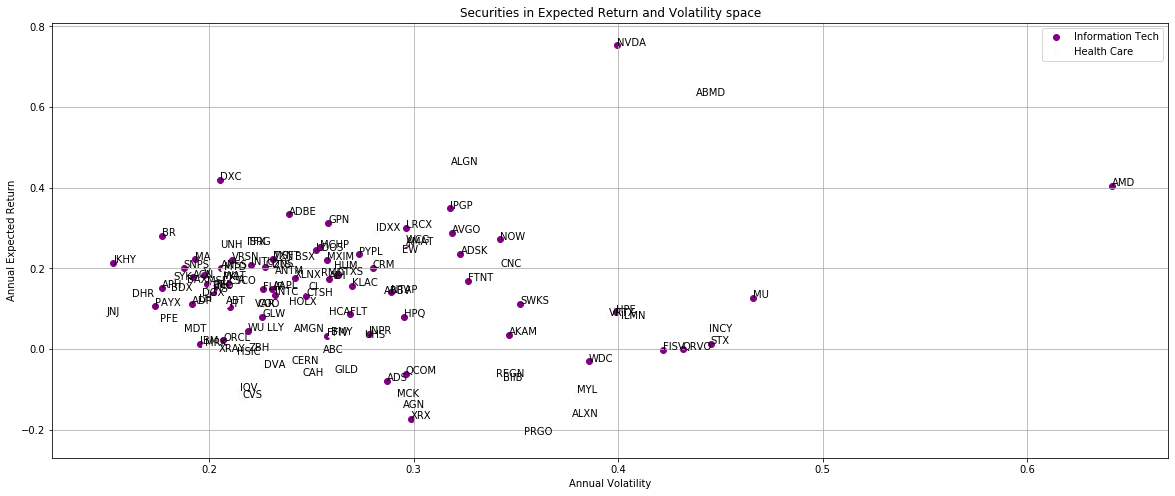

In [6]:
plt.figure(figsize=(20,8))
plt.scatter( x = dfln[Information_Tech_companies].std() * 250**0.5 ,color = 'purple',label = 'Information Tech',
             y =  (dfln[Information_Tech_companies].mean() * 250))
plt.scatter( x = dfln[Health_Care_companies].std() * 250**0.5 , color = 'snow', label = 'Health Care',
             y =  (dfln[Health_Care_companies].mean() * 250) )
plt.legend()
plt.title('Securities in Expected Return and Volatility space')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Expected Return');

plt.grid(True)

for n ,t in enumerate(dfln.columns):
    plt.annotate(t,
                 (dfln[t].std()*250**0.5, dfln[t].mean()*250)
                    )

 A more complete view with annualized  returns distributions for each sector.

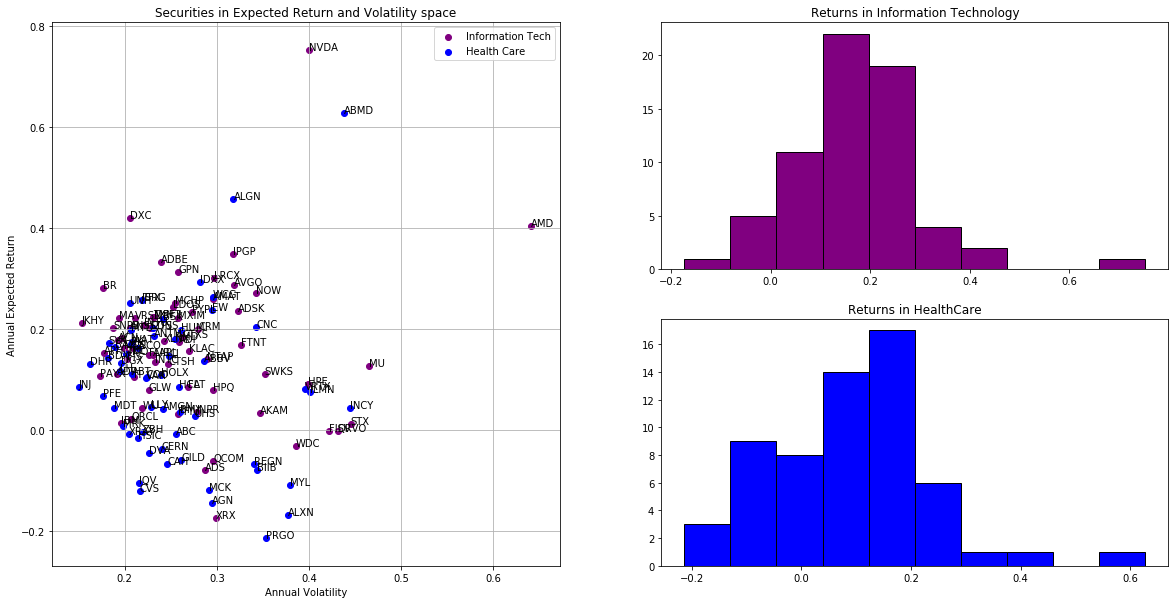

In [10]:
f = plt.figure(figsize=(20,10))
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=f)
ax1 = f.add_subplot(spec2[:, 0])
ax2 = f.add_subplot(spec2[0, 1])
ax3 = f.add_subplot(spec2[1, 1])



ax1.scatter( x = dfln[Information_Tech_companies].std() * 250**0.5 ,color = 'purple',label = 'Information Tech',
             y =  (dfln[Information_Tech_companies].mean() * 250))
ax1.scatter( x = dfln[Health_Care_companies].std() * 250**0.5, color = 'blue', label = 'Health Care',
             y =  (dfln[Health_Care_companies].mean() * 250) )
ax1.legend()
ax1.set_title('Securities in Expected Return and Volatility space')
ax1.set_xlabel('Annual Volatility')
ax1.set_ylabel('Annual Expected Return');


ax2.hist((dfln[Information_Tech_companies].mean() * 250) , color = 'purple' , edgecolor = 'k')
ax2.set_title('Returns in Information Technology')

ax3.hist((dfln[Health_Care_companies].mean() * 250) , color = 'blue' , edgecolor = 'k')
ax3.set_title('Returns in HealthCare')

for n ,t in enumerate(dfln.columns):
    ax1.annotate(t,
                 (dfln[t].std()*250**0.5, dfln[t].mean()*250)
                    )
ax1.grid(True)    
plt.show()

# Consideration up to this point

It is important to notice that all the security with a higher return are the more volatile ones.


\
The concept of EFFICIENCY is one of the keys to understanding Markowitz's intuition. 
Given this space, we can say some securities are more Efficient than others since we can get the same return for a lower level of risk.


\
But there is more...

If we recall back the definition of risk. 

Total risk = Systematic Risk + Market Risk .

Even if we invest in the most efficient security we are not reducing any of the two risk components.

That's why we need a Portfolio.

If we use a Portfolio composed by at least two uncorrelated securities is possible to reach even more efficiency.

In [ ]:
dfln[['PFE','ACN']].corr()

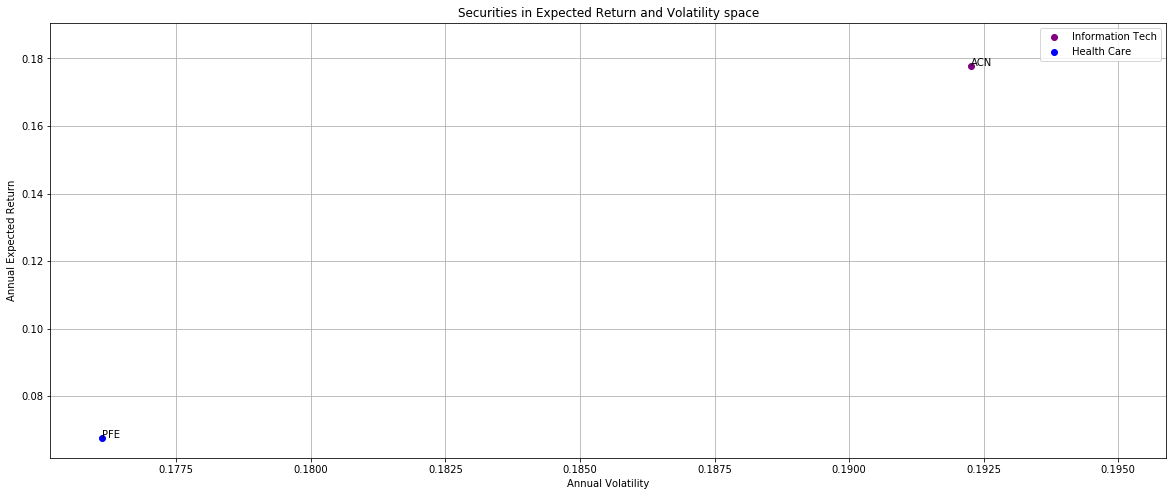

In [11]:
plt.figure(figsize=(20,8))




sec1 = 'ACN'
sec2 = 'PFE'
selected = [sec1,sec2]


plt.scatter( x = dfln[sec1].std() * 250**0.5 ,color = 'purple',label = 'Information Tech',
             y =  (dfln[sec1].mean() * 250))
plt.scatter( x = dfln[sec2].std() * 250**0.5 , color = 'blue', label = 'Health Care',
             y =  (dfln[sec2].mean() * 250) )
plt.legend()
plt.title('Securities in Expected Return and Volatility space')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Expected Return');


for n ,t in enumerate([sec1,sec2]):
    plt.annotate(t,
                 (dfln[t].std()*250**0.5, dfln[t].mean()*250))
    
plt.grid(True)

Portfolio is more efficient! 

\
Our new problem is 
* How much to allocate for each security in the portfolio? 
* Which securities must be used? 
* How do I evaluate many portfolios? 

The answer is not the same for everyone, investment is a really personal thing and must be customized for the investor's needs.

All Investors are risk-averse, but some of them have different levels of risk aversion. 
Some investors would invest in more risky markets because they are looking for high returns, or some others instead would prefer a more conservative approach.

# Efficient Frontier 

To answer the last question SharpeRatio is a proportion between the Risk Premium and the Volatility of the Portfolio.

\
The risk premium is a difference between a Risk-Free Asset and the Portfolio return.


\
**A risk-free asset is an asset that we assume riskfree because of some institution guarantee for it.**

In the real world, there are no risk-free assets, but some debt assets such as Bonds will fail just if the state goes in default. 


\
Some European Bonds are so solid that their returns are close to 0. 

That's because as more a Bond is solid as more investors will require them.
If the demand is high the price rises and returns fall.

Some African Bonds instead are risky, so to acquire them the investors will have higher expectations for the risk taken. 
The demands are low, the price falls and returns rise.

\
What is the role of the Risk-free Asset?

Investors are risk-averse, and some of them will give more importance to reduce volatility rather than looking for high returns.
The risk-Free asset has a defensive role in the portfolio. 

**The optimization of portfolios drive in a certain way the market of bonds and the government spending.**

If a state is considered risky, nobody will invest in it.

\
We said investors might looking for minimum volatility or higher returns.

In case investors prioritize risk aversion. They might be looking for a Minumum Volatility Portfolio.

A portfolio with low volatility, the less volatile one.

In case investors prioritize the efficiency of returns, they might look for the Max Sharpe Ratio Portfolio.


\
Recap:

* Risk-free assets are a defensive asset to reduce volatility
* The Sharpe Ratio is a measure of the Efficiency of the Portfolio in a Return perspective.
* Minimum Volatility Portfolio prioritize low risk
* Max SharpeRatio Portfolio prioritize efficiency

Example in code:


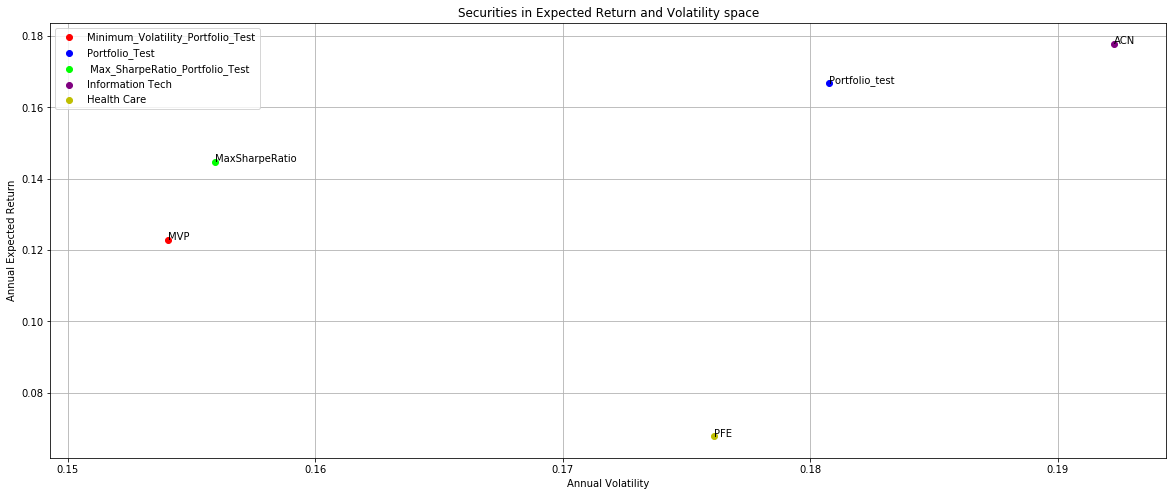

In [12]:
plt.figure(figsize=(20,8))


test_w = np.array([0.5,0.5])

test_w1 = np.array([0.9,0.1])

test_w2 = np.array([0.7,0.3])




sec1 = 'ACN'
sec2 = 'PFE'
selected = [sec1,sec2]

test_portfolio_expReturns = np.dot(dfln[selected].mean()*250 ,test_w )
test_portfolio_Volatility = (np.dot(test_w.T, np.dot(dfln[selected].cov() * 250, test_w)))**0.5

test_portfolio_expReturns1 = np.dot(dfln[selected].mean()*250 ,test_w1)
test_portfolio_Volatility1 = np.sqrt(np.dot(test_w1.T, np.dot(dfln[selected].cov() * 250, test_w1)))


test_portfolio_expReturns2= np.dot(dfln[selected].mean()*250 ,test_w2 )
test_portfolio_Volatility2 = (np.dot(test_w.T, np.dot(dfln[selected].cov() * 250, test_w2)))**0.5


plt.scatter( x =  test_portfolio_Volatility ,color = 'red',label = 'Minimum_Volatility_Portfolio_Test',
             y =  test_portfolio_expReturns)

plt.scatter( x =  test_portfolio_Volatility1 ,color = 'blue',label = 'Portfolio_Test',
             y =  test_portfolio_expReturns1)


plt.scatter( x =  test_portfolio_Volatility2 ,color = 'lime',label = ' Max_SharpeRatio_Portfolio_Test',
             y =  test_portfolio_expReturns2)


plt.scatter( x = dfln[sec1].std() * 250**0.5 ,color = 'purple',label = 'Information Tech',
             y =  (dfln[sec1].mean() * 250))
plt.scatter( x = dfln[sec2].std() * 250**0.5 , color = 'y', label = 'Health Care',
             y =  (dfln[sec2].mean() * 250) )
plt.legend()
plt.title('Securities in Expected Return and Volatility space')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Expected Return');


plt.annotate('MVP',
             (test_portfolio_Volatility,test_portfolio_expReturns)
            )

plt.annotate('Portfolio_test',
             (test_portfolio_Volatility1,test_portfolio_expReturns1)
            )

plt.annotate('MaxSharpeRatio',
             (test_portfolio_Volatility2,test_portfolio_expReturns2)
            )


for n ,t in enumerate([sec1,sec2]):
    plt.annotate(t,
                 (dfln[t].std()*250**0.5, dfln[t].mean()*250))
    
plt.grid(True)

\
Now that we have defined what is efficiency we can introduce the concept of the EFFICIENT FRONTIER

" *The efficient frontier is the set of the point that better manage the concept of efficiency* " 

Every allocation placed below the frontier is not efficient, so it won't be considered in portfolio optimization.




The allocation 50% PFE 50% ACN  is more efficient and less risky than the less volatile stock.
The allocation is even the most conservative among the 2 portfolios. 
\
**The allocation 50/50 PFE ACN is the Minumum Volalatility Portfolio**


\
The allocation 70% ACN 30% PFE is not the most conservative but is indeed more efficient than all the other combinations, we are maximizing efficiency of returns so...
\
**The allocation 70/30 is the MaxSharp Ratio Portfolio**

The Portfolio_test allocation is below the efficient frontier because is in an "inner position" considering the MVP and the Riskiest asset.

**The Portfolio_test won't be a part of the optimal allocations**

Recall the questions of the previous block.

* How much to allocate for each security in the portfolio? 
* Which securities must be used? 
* How do i evaluate many portfolios? 

Now we can answer to all the questions

We can run a simulation for many Portfolios and :

* Select uncorrelated stocks to reduce market risks
* Select the Minumum Volatility Portfolio , for more risk-averse investors.
* Select the MaxSharpeRatio Portfolio, for  the investors who prioritize the efficiency of returns

We assume we are not dealing with a risk-free asset, so Sharpe ratio will just be a ratio returns/ volatility

# Final Simulation

## Complete Simulation Function

In [13]:
def Portfolio_Stocks_Frontier(dfc, security_list, possible_allocations=500, rf=0, style='Purples',w =20,h = 8,visual = True ):
    """
        Create  a map for all possible  allocations for  n securities based on log returns.
        
        Markowitz info : https://en.wikipedia.org/wiki/Modern_portfolio_theory
        
        params:
        dfc = pandas df with close price D1
        possible_allocations = number of combinations 
        security_list = tickers of the securities in your df 
        rf = Risk free asset return
        w = figsize width
        h = figsize height
        Visual = True plot piechart of all weights ,
        ex:
        MVP, MaxSRP, Portfolio_df = Portfolio_Stocks_Frontier(dfc,['SWKS', 'XRX', 'WDC', 'ACN', 'STX', 'MA', 'WU', 'GLW', 'ANSS', 'APH'],500,visual=True)
        
        Required packages : 
        import matplotlib.gridspec as gridspec
        import pandas as pd 
        import numpy as np 
        import seaborn as sns
        import matplotlib.pyplot as plt
        import matplotlib.cm as cm
        from matplotlib.colors import Normalize
        from jupyterthemes import jtplot
        jtplot.style()
        
        Use pip install if nedeed

        Created By Davide Lupis , just to act like i'm cool you know.. """
    # Create ln returns
    dfln = dfc.pct_change().apply(lambda x: np.log(1+x))
    # Create empty lists
    portfolio_ExpReturns = []
    portfolio_Volatilities = []
    stock_weights = []
    for i in range(possible_allocations):

            # Initialize weights
            weights = np.random.random(len(security_list))
            weights /= np.sum(weights)
            # Exp Return
            portfolio_ExpReturn = np.dot(dfln[security_list].mean()* 250,weights ) 
            # Portfolio Volatility
            portfolio_Volatility = (np.dot(weights.T, np.dot(dfln[security_list].cov() * 250, weights)))**0.5
            # Register the results on the lists
            portfolio_ExpReturns.append(portfolio_ExpReturn)
            portfolio_Volatilities.append(portfolio_Volatility)

            stock_weights.append(weights)

        # Dictionary of Volatility and Returns
    Return_Volatility_Dict = {
                              'Returns':     [r for r in portfolio_ExpReturns],
                              'Volatility':  [v for v in portfolio_Volatilities],
                              'SharpeRatio': [(r-rf)/v for r, v in zip(portfolio_ExpReturns, portfolio_Volatilities)],
                                  }


    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for n,symbol in enumerate(security_list):
        Return_Volatility_Dict[symbol+' Weight'] = [weight[n] for weight in stock_weights]
        
    # Create a pandas df     
    Portfolio_df = pd.DataFrame.from_dict(Return_Volatility_Dict)    
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = Portfolio_df['Volatility'].min()
    max_sharpe = Portfolio_df['SharpeRatio'].max()

    # use the min, max values to locate and create the two special portfolios
    MaxSRP = Portfolio_df.loc[Portfolio_df['SharpeRatio'] == max_sharpe]
    MVP = Portfolio_df.loc[Portfolio_df['Volatility'] == min_volatility]
        
    if visual == True:
        
         # Plot the possible Allocations
        my_cmap = cm.get_cmap(style)
        my_norm = Normalize(vmin=-0.2, vmax=0.5)
        f = plt.figure(figsize=(w,h))
        spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=f)

        ax1 = f.add_subplot(spec2[:, 0])
        ax2 = f.add_subplot(spec2[0, 1])
        ax3 = f.add_subplot(spec2[1, 1])

        # Plot Frontier
        plt_frontier = ax1.scatter(y=Return_Volatility_Dict['Returns'], x=Return_Volatility_Dict['Volatility'],
                                   c=Return_Volatility_Dict['SharpeRatio'], cmap=style, edgecolors='k', linewidth=0.6, alpha=0.9, s=20)

        plt.colorbar(plt_frontier, ax=ax1).set_label('Sharpe Ratio')

        ax1.set_ylabel('Annualized Expected Returns')
        ax1.set_xlabel('Annualized Volatility')

        ax1.set_title('Allocations')
        ax1.scatter(x=MaxSRP['Volatility'], y=MaxSRP['Returns'], c='red', marker='D', s=200)
        ax1.scatter(x=MVP['Volatility'], y=MVP['Returns'], c='blue', marker='D', s=200 )
        
        ax1.grid(True)
            # Plot Weights composition for MVP e MaxSRP
        ax2.set_title('Minimum Volatility Portfolio  Weights Composition')
        print('='*30,'MVP Details','='*30)
        print(MVP)
        print('='*30,'MaxSRP Details','='*27)
        print(MaxSRP)
        print('='*80,'Graphs','='*80)
        ax2.pie( MVP[[i for i in MVP.columns if 'Weight' in i ]].values.flatten(), textprops={'color':"k"},
                colors=my_cmap(my_norm(MVP[[ i for i in MVP.columns if 'Weight' in i ]].values.flatten() ) )
                ,labels = [i for i in MVP.columns if 'Weight' in i ]
                ,autopct='%1.3f%%')
        
        ax3.set_title('Max SharpeRatio Portfolio  Weights Composition')
        ax3.pie( MaxSRP[[i for i in MaxSRP.columns if 'Weight' in i ]].values.flatten(), textprops={'color':"k"},
                colors=my_cmap(my_norm(MaxSRP[[ i for i in MaxSRP.columns if 'Weight' in i ]].values.flatten() ) )
                ,labels = [i for i in MaxSRP.columns if 'Weight' in i ]
                ,autopct='%1.0f%%')
                                                                    
        plt.show()
        print('='*166)
        return MVP, MaxSRP,Portfolio_df
    else:
        return MVP, MaxSRP,Portfolio_df
        print('='*80,'Graphs','='*80)

##  Which Security do i select ? 

To maximize the diversification we can select stocks that are completely correlated in a negative way, but we 'll not have any profit.
We then select uncorrelated stocks to reduce the risk and take advantage of the returns for each stock

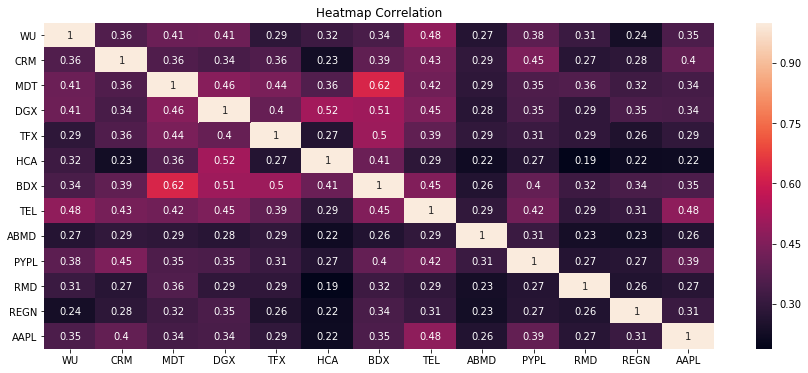

In [14]:
plt.figure(figsize=(15,6))
#Select every 10 
sns.heatmap(dfln.iloc[:,::10].corr(),annot=True)
plt.title('Heatmap Correlation');

In [15]:
stocks_list = dfln.iloc[:,::20].columns.tolist()

============================== MVP Details ==============================
      Returns  Volatility  SharpeRatio  WU Weight  MDT Weight  TFX Weight  \
5704  0.13067    0.146387     0.892634   0.142229    0.175376    0.098828   

      BDX Weight  ABMD Weight  RMD Weight  AAPL Weight  
5704    0.255318     0.004721    0.115229     0.208299  
============================== MaxSRP Details ===========================
       Returns  Volatility  SharpeRatio  WU Weight  MDT Weight  TFX Weight  \
3326  0.317424    0.197613      1.60629   0.001895    0.011895    0.520463   

      BDX Weight  ABMD Weight  RMD Weight  AAPL Weight  
3326    0.065114     0.228737    0.138726     0.033169  
================================================================================ Graphs ================================================================================


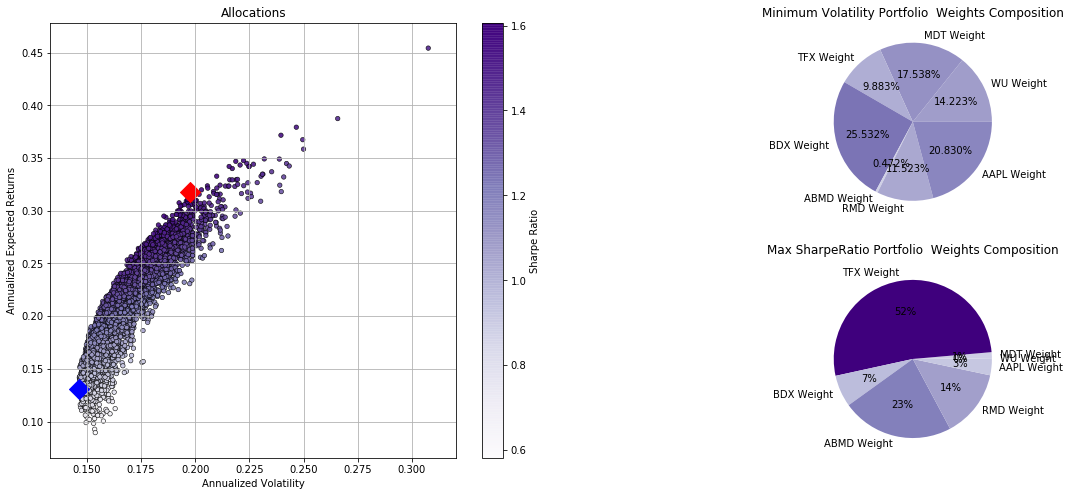

In [16]:
MVP, MaxSRP, Portfolio_df = Portfolio_Stocks_Frontier(dfc,stocks_list,6000,visual=True)

# Test Random Portfolios

I've built the function to simulate all the allocation but is possible to get  3 pandas df that contains the MVP-MaxSRPortfolio and the Total df of simulation if you want to expand your research.

============================== MVP Details ==============================
      Returns  Volatility  SharpeRatio  CDNS Weight  ADI Weight  REGN Weight  \
383  0.096695    0.167485     0.577335     0.114802    0.132695     0.077741   

     CRM Weight  NTAP Weight  AMAT Weight  MU Weight  NOW Weight  CAH Weight  \
383    0.079157     0.066269     0.067641   0.008408    0.053974    0.184015   

     MDT Weight  
383    0.215297  
============================== MaxSRP Details ===========================
      Returns  Volatility  SharpeRatio  CDNS Weight  ADI Weight  REGN Weight  \
222  0.194504     0.19873     0.978738      0.20856    0.213903     0.010059   

     CRM Weight  NTAP Weight  AMAT Weight  MU Weight  NOW Weight  CAH Weight  \
222    0.159275     0.036193     0.209142   0.012193     0.08094    0.020208   

     MDT Weight  
222    0.049527  
================================================================================ Graphs ================================================

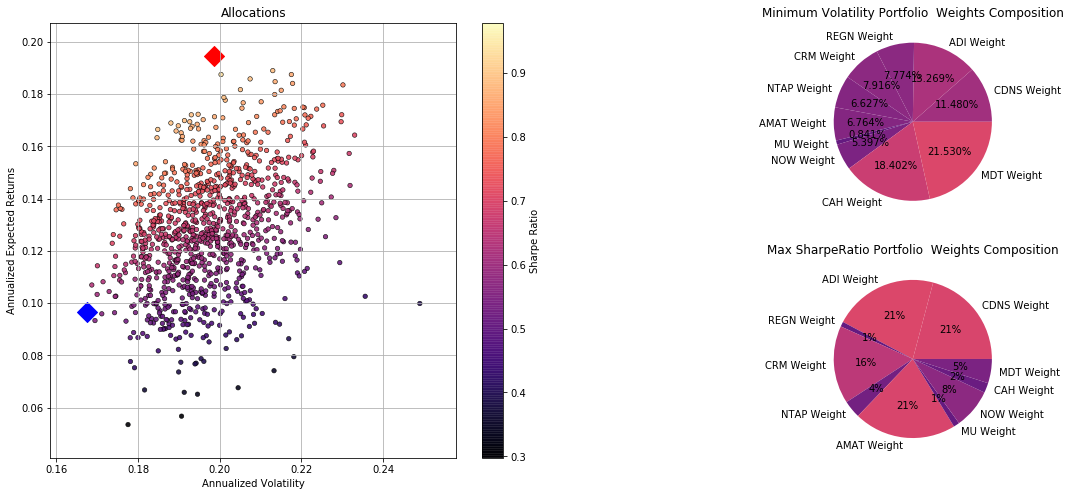

In [19]:
# Select random stocks
random_list = random.choices(dfln.columns,k= 10)

# Simulation
MVP, MaxSRP, Portfolio_df = Portfolio_Stocks_Frontier(dfc,random_list,1000,visual=True,style='magma')